In [12]:
import pyautogui
from PIL import Image, ImageDraw
import pywinctl
import pyautogui
import time
from PIL import Image
import tkinter as tk
import numpy as np
import cv2

In [13]:
import pywinctl

# Locate the "Super Auto Pets" window
window = pywinctl.getWindowsWithTitle('Super Auto Pets')

if window:
    app_window = window[0]
    print(f"Window found: {app_window}")
else:
    print("Application 'Super Auto Pets' not found.")

Window found: <MacOSWindow left="774", top="304", width="718", height="453", title="Super Auto Pets">


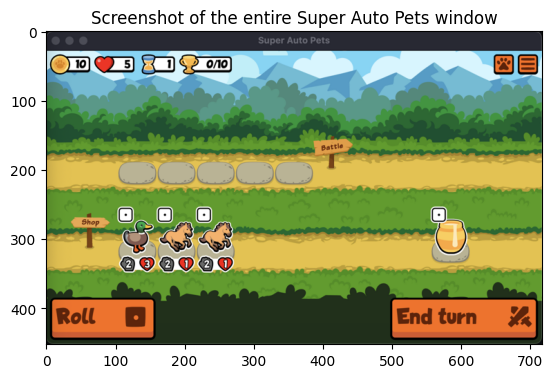

In [14]:
# Capture a screenshot of the entire Super Auto Pets window
left = app_window.left
top = app_window.top
width = app_window.width
height = app_window.height
region = (left, top, width, height)

screenshot = pyautogui.screenshot(region=region)
import matplotlib.pyplot as plt

plt.imshow(screenshot)
plt.title("Screenshot of the entire Super Auto Pets window")
plt.show()

In [15]:
def find_shop_area(screenshot):
    """
    Detects the 'Shop' sign and returns its bounding box (x, y, w, h) regardless of resolution.
    Uses SIFT feature matching with FLANN.
    """
    shop_template = cv2.imread("../assets/shop-sign.png", cv2.IMREAD_UNCHANGED)

    if shop_template is None:
        print("Error: Template image not found.")
        return None

    # Convert images to grayscale
    screenshot_gray = cv2.cvtColor(screenshot, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(shop_template, cv2.COLOR_BGR2GRAY)

    # Use SIFT feature detection (better for scale changes)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(template_gray, None)
    kp2, des2 = sift.detectAndCompute(screenshot_gray, None)

    if des1 is None or des2 is None:
        print("Error: No features detected.")
        return None

    # FLANN-based matcher for efficiency
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test (Lowe's ratio test)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 4:
        print("Not enough good matches found.")
        return None

    # Get corresponding points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography (to estimate position and scale)
    matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if matrix is None:
        print("Homography calculation failed.")
        return None

    # Get the original template's bounding box coordinates
    h, w = template_gray.shape
    pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)

    # Transform the points to match the detected area
    transformed_pts = cv2.perspectiveTransform(pts, matrix)

    # Compute bounding box of transformed points
    x, y, w, h = cv2.boundingRect(transformed_pts)

    return int(x), int(y), int(w), int(h)

In [16]:
screenshot_np = np.array(screenshot)
shop_screen_pos = find_shop_area(screenshot_np)

if shop_screen_pos:
    print(f"Shop sign bounding box: {shop_screen_pos}")  # Outputs (x, y, width, height)
else:
    print("Shop sign not found!")

Shop sign bounding box: (34, 262, 61, 57)


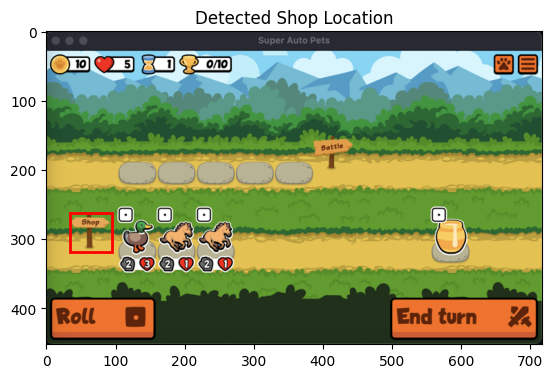

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(screenshot_np)

# Create a Rectangle patch
if shop_screen_pos:
    rect = patches.Rectangle(
        (shop_screen_pos[0], shop_screen_pos[1]),
        shop_screen_pos[2],
        shop_screen_pos[3],
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.title("Detected Shop Location")
plt.show()

In [5]:
template_resolution = [1920, 1080]  # height, width
curr_geometry = [app_window.width, app_window.height]
dimensions_scale = np.array(curr_geometry) / np.array(template_resolution)

# template dimensions -> to be scaled if necessary
img_n_width = 130
bboxes = [
    [10, 0, 140, img_n_width],
    [155, 0, 285, img_n_width],
    [300, 0, 430, img_n_width],
    [445, 0, 575, img_n_width],
    [590, 0, 720, img_n_width],
    [1015, 0, 1145, img_n_width],
    [1160, 0, 1290, img_n_width],
    # [730, 0, 860, img_n_width],
    # [875, 0, 1005, img_n_width],
]
images = []
for bbox in bboxes:
    bbox[0] = dimensions_scale[0] * bbox[0]
    bbox[1] = dimensions_scale[1] * bbox[1]
    bbox[2] = dimensions_scale[0] * bbox[2]
    bbox[3] = dimensions_scale[1] * bbox[3]

In [ ]:
# Create a new Tkinter window
overlay_window = tk.Tk()
overlay_window.title("SAPAI Overlay")

# Set the dimensions of the window
overlay_window.geometry(
    f"{app_window.width}x{app_window.height}+{app_window.left}+{app_window.top}"
)

#overlay_window.attributes("-alpha", 0.5)  # 50% transparent window

overlay_window.attributes("-transparent", True)  # 50% transparent window

# Create a canvas and add it to the window
canvas = tk.Canvas(
    overlay_window,
    width=app_window.width,
    height=app_window.height,
    bg='systemTransparent',
    highlightthickness=0,
)

# Draw the bounding boxes as rectangles
# for bbox in bboxes:
    # canvas.create_rectangle(bbox[0], bbox[1], bbox[2], bbox[3], outline="red")

# Draw the shop bounding box as a rectangle
if shop_screen_pos:
    canvas.create_rectangle(
        shop_screen_pos[0], shop_screen_pos[1],
        shop_screen_pos[0] + shop_screen_pos[2], shop_screen_pos[1] + shop_screen_pos[3],
        outline="blue"
    )

# Create a standard rectangle at position (0, 0)
canvas.create_rectangle(0, 0, 100, 100, outline="red")

canvas.pack()


# Run the Tkinter event loop
overlay_window.mainloop()

In [ ]:
# Capture screenshots at the bbox positions
for bbox in bboxes:
    left = int(app_window.left + bbox[0])
    top = int(app_window.top + bbox[1])
    width = int(bbox[2] - bbox[0])
    height = int(bbox[3] - bbox[1])
    region = (left, top, width, height)

    screenshot = pyautogui.screenshot(region=region)
    images.append(screenshot)
    import matplotlib.pyplot as plt

    plt.imshow(screenshot)
    plt.title(f"Screenshot at ({left}, {top})")
    plt.show()